In [1]:
# started 11-4-2025

In [2]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
print(xgboost.__version__)


3.1.1


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
X_train = pd.read_csv("../normalized split data/X_train.csv")
X_test = pd.read_csv("../normalized split data/X_test.csv")
y_train = pd.read_csv("../normalized split data/y_train.csv")
y_test = pd.read_csv("../normalized split data/y_test.csv")

In [6]:
y_train

,FIRE_SIZE
0,0.301030
1,1.918197
2,2.712774
3,0.477121
4,0.477121
...,...
1809,2.204120
1810,1.301030
1811,0.324282
1812,0.477121


In [7]:
mad = (y_train["FIRE_SIZE"] - y_train["FIRE_SIZE"].mean()).abs().mean()
mad

np.float64(0.795587537317952)

In [8]:
xgb_model = XGBRegressor(
    n_estimators=5000,      # number of boosting rounds (trees)
    learning_rate=0.001,
    max_depth=6,           # maximum depth of each tree
    subsample=0.8,         # fraction of samples used per tree
    colsample_bytree=0.8,  # fraction of features used per tree
    random_state=5    
)

In [9]:
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
xgb_y_pred = xgb_model.predict(X_test)

In [11]:
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mse = mean_squared_error(y_test, xgb_y_pred)


print(f"test MAE: {xgb_mae:.3f}")
print(f"test R2: {xgb_r2:.3f}")
print(f"test mse: {xgb_mse:.3f}")

test MAE: 0.717
test R2: 0.191
test mse: 0.834


In [12]:
xgb_y_pred_tr = xgb_model.predict(X_train)

xgb_mae_tr = mean_absolute_error(y_train, xgb_y_pred_tr)
xgb_r2_tr = r2_score(y_train, xgb_y_pred_tr)

print(f"train MAE: {xgb_mae_tr:.3f}")
print(f"train R2: {xgb_r2_tr:.3f}")

train MAE: 0.483
train R2: 0.631


In [13]:
from sklearn.model_selection import cross_val_score, KFold

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_median_absolute_error')

print(scores.mean(), scores.std())

-0.5961651394974025 0.041668262036962916


<Axes: ylabel='Count'>

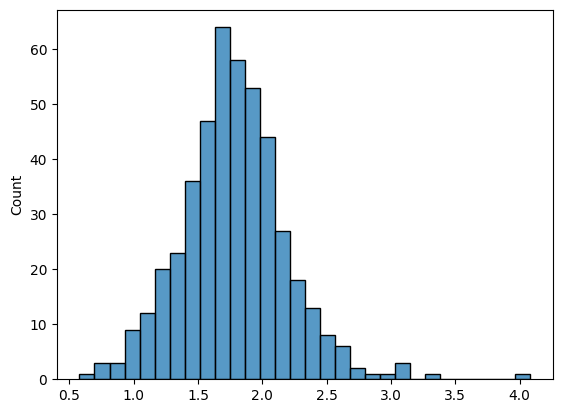

In [16]:
sns.histplot(data=xgb_y_pred, bins=30, kde=False)


In [17]:
import shap
import matplotlib.pyplot as plt

In [18]:
features = ['temp_max_F','humidity_pct','precip_in','windspeed_mph','ndvi','pop_density','slope']

In [19]:
background = X_test.iloc[:300].to_numpy()
X_test_sample = X_test.iloc[:300]
feature_names = X_test.columns.tolist()

In [20]:
shap_explainer = shap.Explainer(xgb_model.predict,X_test_sample)

In [21]:
shap_values = shap_explainer(X_test_sample)

ExactExplainer explainer: 301it [02:14,  2.18it/s]                         


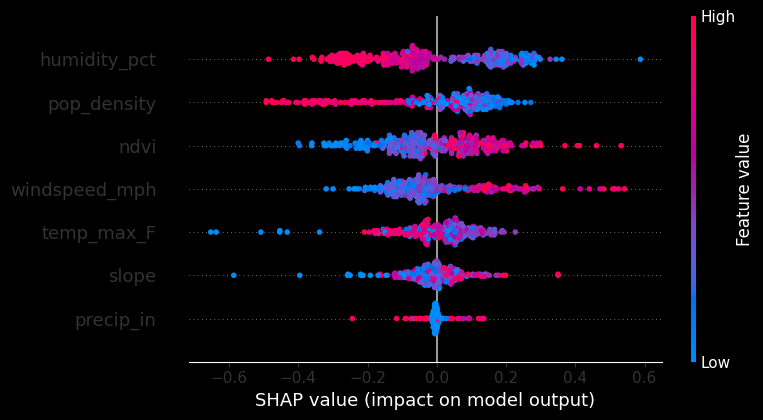

<Figure size 640x480 with 0 Axes>

In [43]:
shap.summary_plot(shap_values,X_test_sample)

plt.rcParams.update({
    "figure.facecolor": "black", # change this, run twice
    "axes.facecolor": "black",
    "savefig.facecolor": "black",
    "text.color": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "axes.edgecolor": "white",
})

# 2) create the SHAP plot but don't show it yet
# 3) grab the current figure and restyle every axes (this hits colorbar, invisible axes, etc.)
fig = plt.gcf()

for ax in fig.axes:
    # backgrounds
    ax.set_facecolor("black")

    # spine colors
    for spine in ax.spines.values():
        spine.set_color("white")

    # tick labels
    ax.tick_params(colors="white", which="both")

    # axis labels + title
    if ax.xaxis.label: ax.xaxis.label.set_color("white")
    if ax.yaxis.label: ax.yaxis.label.set_color("white")
    if ax.title: ax.title.set_color("white")

    # any text objects (feature names, annotations)
    for txt in ax.texts:
        txt.set_color("white")

    # make sure tick label objects are white (covers weird cases)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color("white")

    # colorbar axes sometimes need explicit y-axis tick color set
    try:
        for tick in ax.yaxis.get_ticklabels():
            tick.set_color("white")
        for tick in ax.xaxis.get_ticklabels():
            tick.set_color("white")
    except Exception:
        pass

# 4) final show
plt.tight_layout()
plt.show()


In [69]:
from lime import lime_tabular

In [70]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),
    feature_names=features,
    mode="regression"
)

In [71]:
i = 7  # index of the test sample to explain
x_instance = X_test.to_numpy()[i]
pred_for_i = xgb_model.predict(np.array([x_instance]))
actual_i = y_test.to_numpy()[i]

exp = explainer.explain_instance(
    data_row=x_instance,
    predict_fn=xgb_model.predict
)

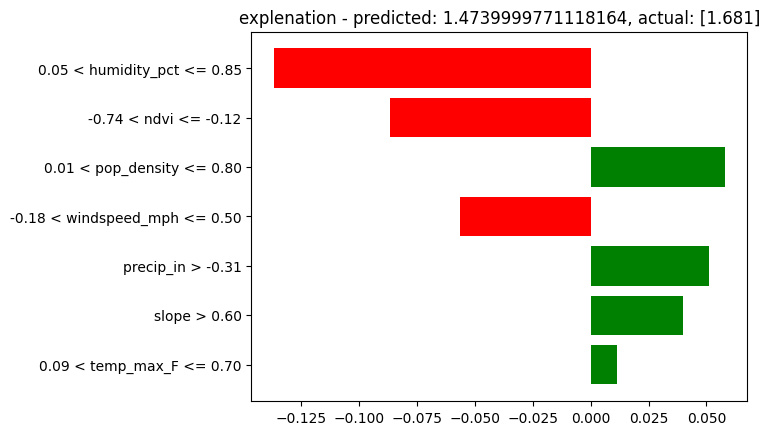

In [72]:
exp.as_pyplot_figure()
plt.title(label=f"explenation - predicted: {(np.round(pred_for_i,3))[0]}, actual: {np.round(actual_i,3)}")
plt.show()

In [73]:
from sklearn.inspection import permutation_importance

In [74]:
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10)

In [75]:
importance = pd.Series(result.importances_mean, index=X_test.columns)

<Axes: >

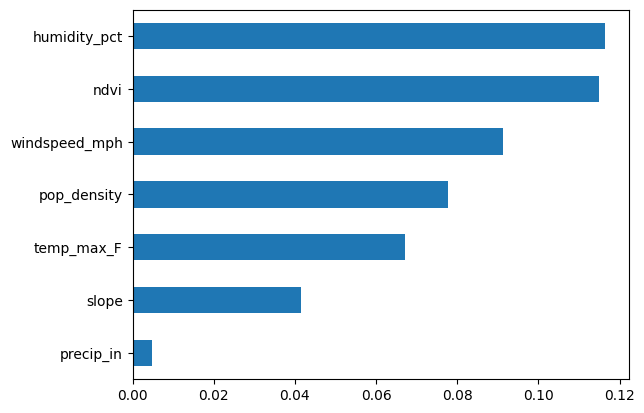

In [76]:
importance.sort_values().plot.barh()

In [77]:
from sklearn.inspection import PartialDependenceDisplay

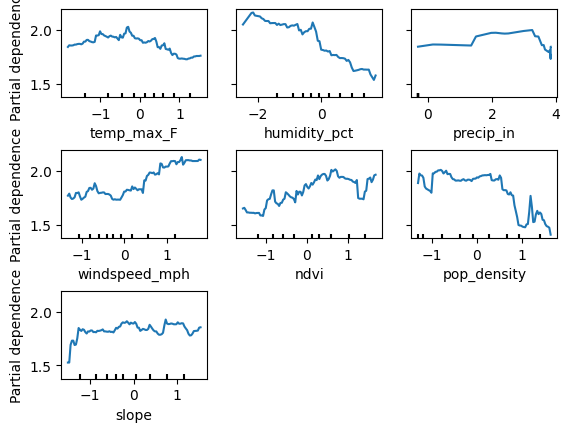

In [81]:
PartialDependenceDisplay.from_estimator(xgb_model, X_train.iloc[:300], features=features)
plt.subplots_adjust(hspace=0.6)
plt.show()


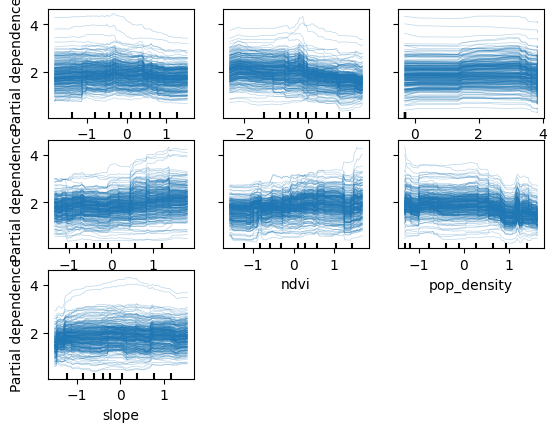

In [31]:
PartialDependenceDisplay.from_estimator(xgb_model, X_train.iloc[:300], features=features, kind="individual")

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
# pip install explainerdashboard or pip install explainerdashboard[dash] for full
# https://explainerdashboard.readthedocs.io/en/latest/dashboards.html 

In [33]:
print("xgboost:", xgboost.__version__)
print("shap:   ", shap.__version__)
print("type(xgb_model):", type(xgb_model))
print("booster attrs:", xgb_model.get_booster().attributes())

xgboost: 3.1.1
shap:    0.49.1
type(xgb_model): <class 'xgboost.sklearn.XGBRegressor'>
booster attrs: {}


In [ ]:
explainer = RegressionExplainer(xgb_model, X_test.iloc[:300], y_test.iloc[:300],shap="kernel")

ExplainerDashboard(explainer,decision_trees=False).run(mode="inline") # add mode="inline" to run() to show in notebook
# if re-running, may need to run in new cell to avoid errors
#   or restart kernel or ExplainerDashboard().terminate(8050)

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.KernelExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


  0%|          | 0/300 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...


c:\Users\Yash\AppData\Local\Programs\Python\Python312\Lib\site-packages\dash\dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))


Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


In [13]:
X_test

,temp_max_F,humidity_pct,precip_in,windspeed_mph,ndvi,pop_density,slope
0,0.175755,-0.911423,-0.306948,-2.142293,-0.577436,0.902966,-0.231593
1,-0.001675,0.210161,-0.306948,2.701373,2.148222,1.846058,-1.523210
2,1.802563,-1.926190,-0.306948,1.491034,-0.503677,-0.495398,-1.440164
3,0.204392,0.851066,-0.306948,0.309987,0.071812,-0.705327,-0.928991
4,0.497541,0.103343,-0.306948,-0.808181,-1.075736,0.745581,-0.362739
...,...,...,...,...,...,...,...
449,0.193632,0.477205,-0.306948,-1.546200,0.179020,-1.083997,0.458487
450,1.695301,-0.804606,-0.306948,-1.602971,1.391750,0.008212,0.794210
451,-1.594069,-0.003474,-0.306948,-1.006878,0.080389,0.875619,-1.011376
452,0.247263,-1.338693,-0.306948,0.980097,-1.902519,-0.688108,-1.205542
